# Exploring candidates to use as ground truth for training the model

2023-06-02

In [177]:

import geopandas as gpd
import pandas as pd
import ee
import folium
import shapely.geometry
from shapely.geometry import shape
from matplotlib import pyplot as plt

# ee.Authenticate()
ee.Initialize(project='gsl-monitoring')

## Read

The `image_ids` were identified as the images with coverage over the target area during the target time period using the metadata saved in `scripts/save-historical-image-metadata.py`.

In [178]:
gdf = gpd.read_file('../../data/definitions/preliminary-roi.geojson')
polygon_geojson = shapely.geometry.mapping(gdf.loc[0, 'geometry'])
roi = ee.Geometry.Polygon(polygon_geojson['coordinates'])

# create image collection
collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(roi) \
    .filterDate('2014-01-01', '2023-05-30') \
    .select('VV')

image_ids = [
    'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SSV_20161118T133343_20161118T133408_013997_0168E2_0E34',
    'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SSV_20161025T133344_20161025T133409_013647_015DFD_D6D4',
    'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SSV_20161001T133344_20161001T133409_013297_015303_46D8',
    'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SSV_20160914T012714_20160914T012739_013042_014AAB_8E21',
    'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SSV_20160907T133338_20160907T133403_012947_0147A1_6662',
    'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SSV_20160814T133337_20160814T133402_012597_013BFD_B0DF',
    ]

## Function definitions

In [179]:
def get_image_collection(image_ids):
    def get_images(image_id):
        return ee.Image(image_id)

    images = ee.ImageCollection.fromImages(list(map(get_images, image_ids)))\
                                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
                                .filter(ee.Filter.eq('instrumentMode', 'IW'))
    return images

def print_image_properties(images):
    first_image = ee.Image(images.first())
    properties = first_image.getInfo()['properties']
    print(f"Image pass direction: {properties['orbitProperties_pass']}")
    print(f"Image polarization: {properties['transmitterReceiverPolarisation']}")

def lee_filter(image, size):
    mean_square = image.reduceNeighborhood(
        reducer=ee.Reducer.mean().unweighted(),
        kernel=ee.Kernel.square(size),
    )
    sigma = image.reduceNeighborhood(
        reducer=ee.Reducer.stdDev().unweighted(),
        kernel=ee.Kernel.square(size),
    )
    return image.where(sigma.gt(0.0), mean_square)

def lee_sigma(image, look_window, sigma_v):
    """Applies a Lee Sigma filter to an image."""
    mean = image.reduceNeighborhood(
        ee.Reducer.mean(), ee.Kernel.square(look_window))

    variance = image.reduceNeighborhood(
        ee.Reducer.variance(), ee.Kernel.square(look_window))

    sigma_v = variance.sqrt().divide(mean)

    return image.where(sigma_v.gt(sigma_v), mean)

def apply_speckle_filter(images, size=3):
    return images.map(lambda img: lee_sigma(img, 7, 0.25))

def to_linear(img):
    # from db to linear
    linear_vv = ee.Image(10.0).pow(img.select(['VV']).divide(10.0))
    img = img.addBands(linear_vv, overwrite=True).select(['VV','angle'])
    return img

def convert_to_linear_units(images):
    return images.map(to_linear)

def min_max_normalize(img, roi):
    stats = img.reduceRegion(reducer=ee.Reducer.minMax(), geometry=roi, maxPixels=1e12)
    min_value = ee.Number(stats.get('VV_min'))
    max_value = ee.Number(stats.get('VV_max'))
    return img.subtract(min_value).divide(max_value.subtract(min_value))

def normalize_collection(images, roi):
    return images.map(lambda img: min_max_normalize(img, roi))

def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = "Map Data © Google Earth Engine",
        name = name,
        overlay = True,
        control = True
    ).add_to(self)

def create_binary_mask(image, threshold):
    return image.lt(threshold).rename('binary_mask')

def show_binary_mask(image, roi, vis_params, threshold=-25):
    folium.Map.add_ee_layer = add_ee_layer
    my_map = folium.Map(location=[roi.centroid().coordinates().get(1).getInfo(), 
                                  roi.centroid().coordinates().get(0).getInfo()], zoom_start=8)
    mask = create_binary_mask(image, threshold)
    my_map.add_ee_layer(mask, vis_params, 'Binary Mask')
    my_map.add_child(folium.LayerControl())
    return my_map

def show_map(image, roi, vis_params):
    folium.Map.add_ee_layer = add_ee_layer
    my_map = folium.Map(location=[roi.centroid().coordinates().get(1).getInfo(), 
                                  roi.centroid().coordinates().get(0).getInfo()], zoom_start=8)
    my_map.add_ee_layer(image, vis_params, 'Normalized SAR Image')
    my_map.add_child(folium.LayerControl())
    return my_map

## Process

In [180]:
images = get_image_collection(image_ids)
print_image_properties(images)

filtered_collection = apply_speckle_filter(images)
linear_collection = convert_to_linear_units(filtered_collection)
normalized_collection = normalize_collection(linear_collection, roi)

Image pass direction: DESCENDING
Image polarization: ['VV']


## Visualize image

### Linear

In [181]:
vis_params = {
    'min': -25,
    'max': -5,
    'palette': ['#1b63e0', 'white', '#e0981b']
}

image = ee.Image(linear_collection.toList(images.size()).get(1)).select('VV')
my_map = show_map(image, roi, vis_params)
display(my_map)

In [ ]:
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['#1b63e0', 'white', '#e0981b']
}

image = ee.Image(normalized_collection.toList(images.size()).get(1)).select('VV')
my_map = show_map(image, roi, vis_params)
display(my_map)

## Evaluate threshold candidates

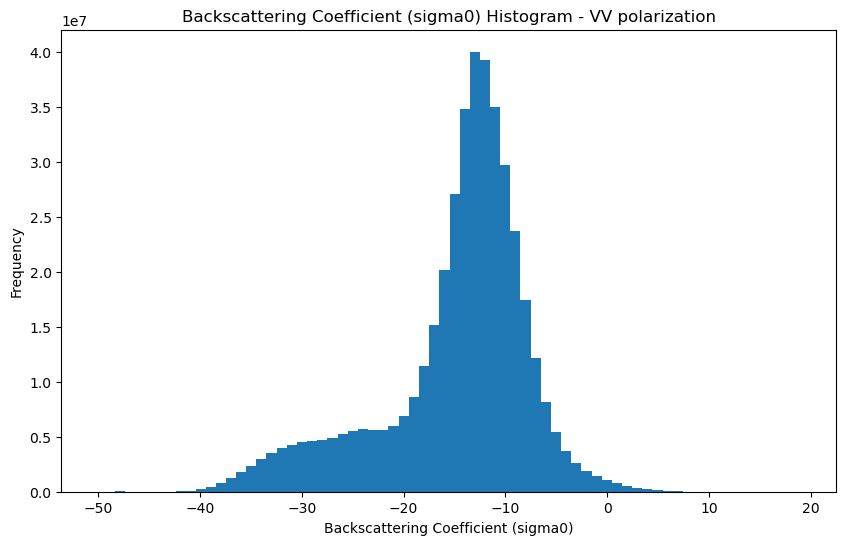

In [ ]:
image = ee.Image(filtered_collection.toList(images.size()).get(1)).select('VV')
geometry = image.geometry()

histogram = image.reduceRegion(
    reducer=ee.Reducer.histogram(maxBuckets=100), 
    geometry=geometry, 
    scale=10, 
    maxPixels=1e9
)
hist_info = histogram.getInfo()
vv_data = hist_info['VV']

plt.figure(figsize=(10,6))
plt.bar(vv_data['bucketMeans'], vv_data['histogram'], width=vv_data['bucketWidth'], align='edge')
plt.title("Backscattering Coefficient (sigma0) Histogram - VV polarization")
plt.xlabel("Backscattering Coefficient (sigma0)")
plt.ylabel("Frequency")
plt.show()

## Visualize threshold mask

In [ ]:
vis_params_mask = {
    # 'min': 0,
    # 'max': 1,
    'palette': ['white', 'black']
}

my_map_mask = show_binary_mask(image, roi, vis_params_mask, threshold=-20)
display(my_map_mask)

## Export image

In [ ]:
image = ee.Image(normalized_collection.toList(images.size()).get(1)).select('VV')

image.getInfo()
print(image.projection().getInfo())
image = image.reproject('EPSG:6341', scale=image.projection().nominalScale())
print(image.projection().getInfo())

{'type': 'Projection', 'crs': 'EPSG:32612', 'transform': [10, 0, 265363.8038094812, 0, -10, 4661937.729569972]}
{'type': 'Projection', 'crs': 'EPSG:6341', 'transform': [10, 0, 0, 0, -10, 0]}


In [ ]:
image.getInfo()

# image.get('system:time_start').getInfo()

{'type': 'Image',
 'bands': [{'id': 'VV',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [28551, 21420],
   'crs': 'EPSG:32612',
   'crs_transform': [10, 0, 265363.8038094812, 0, -10, 4661937.729569972]}],
 'properties': {'system:index': 'S1A_IW_GRDH_1SSV_20161025T133344_20161025T133409_013647_015DFD_D6D4'}}

In [ ]:
task = ee.batch.Export.image.toDrive(
    image=image,
    description='S1A_IW_GRDH_1SSV_20161025T133344_20161025T133409_013647_015DFD_D6D4',
    # scale=10, # if not provided, the native resolution of the image will be used
    maxPixels=1e13,
    region=roi.getInfo()['coordinates'],
    fileFormat='GeoTIFF',
    formatOptions={'cloudOptimized': True}
)

task.start()
task.status()

{'state': 'READY',
 'description': 'S1A_IW_GRDH_1SSV_20161025T133344_20161025T133409_013647_015DFD_D6D4',
 'creation_timestamp_ms': 1685926433758,
 'update_timestamp_ms': 1685926433758,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'N5V4DOFARYSWFIUCFJEG2RCQ',
 'name': 'projects/gsl-monitoring/operations/N5V4DOFARYSWFIUCFJEG2RCQ'}

In [ ]:
task.status()

{'state': 'RUNNING',
 'description': 'S1A_IW_GRDH_1SSV_20161025T133344_20161025T133409_013647_015DFD_D6D4',
 'creation_timestamp_ms': 1685926433758,
 'update_timestamp_ms': 1685926441174,
 'start_timestamp_ms': 1685926441097,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'N5V4DOFARYSWFIUCFJEG2RCQ',
 'name': 'projects/gsl-monitoring/operations/N5V4DOFARYSWFIUCFJEG2RCQ'}

## Evaluate optical imagery

In [94]:
gdf = gpd.read_file('../../data/definitions/preliminary-roi.geojson')
polygon_geojson = shapely.geometry.mapping(gdf.loc[0, 'geometry'])
roi = ee.Geometry.Polygon(polygon_geojson['coordinates'])

image_collection = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate('2016-09-01', '2016-11-30') \
    .filterBounds(roi) \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10) \
    .select(['B4', 'B3', 'B2'])

image_collection.size().getInfo()

# list assets
image_collection.aggregate_array('system:id').getInfo()

# sort collection by size
image_collection = image_collection.sort('system:asset_size', False) 
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Map Data © Google Earth Engine',
        name = name,
        overlay = True,
        control = True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2']
}

def show_map(image, roi, vis_params, name):
    my_map = folium.Map(location=[roi.centroid().coordinates().get(1).getInfo(), 
                                  roi.centroid().coordinates().get(0).getInfo()], zoom_start=8)
    my_map.add_ee_layer(image, vis_params, name)
    my_map.add_child(folium.LayerControl())
    return my_map

image = ee.Image(image_collection.toList(image_collection.size()).get(8))
print(image.get('system:id').getInfo())
my_map = show_map(image, roi, vis_params, 'Normalized SAR Image')
display(my_map)

# COPERNICUS/S2/20161122T182702_20161122T182802_T12TUL
# COPERNICUS/S2/20161122T182702_20161122T214532_T12TUL
# COPERNICUS/S2/20160913T181942_20160913T182213_T12TUL (quite good)
# COPERNICUS/S2/20160913T181942_20160913T232315_T12TUL

## Evaluate multiband SAR imagery

In [173]:
gdf = gpd.read_file('../../data/definitions/preliminary-roi.geojson')
polygon_geojson = shapely.geometry.mapping(gdf.loc[0, 'geometry'])
roi = ee.Geometry.Polygon(polygon_geojson['coordinates'])

# create image collection
collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(roi) \
    .filterDate('2014-01-01', '2023-05-30') \
    .select(['VV', 'VH'])

image_ids = [
    # 'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SSV_20161118T133343_20161118T133408_013997_0168E2_0E34',
    'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SSV_20161025T133344_20161025T133409_013647_015DFD_D6D4',
    'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SSV_20161001T133344_20161001T133409_013297_015303_46D8',
    'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SSV_20160914T012714_20160914T012739_013042_014AAB_8E21',
    'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SSV_20160907T133338_20160907T133403_012947_0147A1_6662',
    'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SSV_20160814T133337_20160814T133402_012597_013BFD_B0DF',
    ]

In [175]:
def get_image_info(image):
    info = image.getInfo()
    date = ee.Date(info['properties']['system:time_start']).format('YYYY-MM-dd').getInfo()
    bands = info['bands']
    bands = [band['id'] for band in bands]  # extract band names
    id = info['id']
    return {"date": date, "bands": bands, "id": id}

# Get the collection without selecting specific bands
collection_no_bands = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(roi) \
    .filterDate('2014-01-01', '2023-05-30')

# Get the number of images
n = collection_no_bands.size().getInfo()

info_list = []
# Get information for each image
for i in range(n):
    image = ee.Image(collection_no_bands.toList(n).get(i))
    info = get_image_info(image)
    info_list.append(info)

# Convert the list of dictionaries to pandas DataFrame
df = pd.DataFrame(info_list)

# Convert bands from lists to strings
df['bands'] = df['bands'].apply(lambda bands: ', '.join(bands))

# Show DataFrame
df


,date,bands,id
0,2015-03-24,"VV, VH, angle",COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20150324T01...
1,2015-03-24,"VV, VH, angle",COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20150324T01...
2,2015-03-29,"VV, VH, angle",COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20150329T01...
3,2015-03-31,"VV, VH, angle",COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20150331T01...
4,2016-03-13,"VV, VH, angle",COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20160313T01...
...,...,...,...
1127,2021-12-23,"VV, VH, angle",COPERNICUS/S1_GRD/S1B_IW_GRDH_1SDV_20211223T01...
1128,2016-09-27,"VV, angle",COPERNICUS/S1_GRD/S1B_IW_GRDH_1SSV_20160927T01...
1129,2016-10-02,"VV, angle",COPERNICUS/S1_GRD/S1B_IW_GRDH_1SSV_20161002T01...
1130,2016-10-02,"VV, angle",COPERNICUS/S1_GRD/S1B_IW_GRDH_1SSV_20161002T01...


In [176]:
# sort and save
# df.to_csv('../../data/gee/gee-sentinel-1-band-info.csv', index=False)

In [168]:
def lee_filter(image):
    # This is a sample filter, replace with actual Lee filter
    return image.reduceNeighborhood(
        reducer=ee.Reducer.mean(),
        kernel=ee.Kernel.square(7, 'pixels'),
    )

def convert_to_linear(image):
    # Assuming image data is in decibels
    return ee.Image(10).pow(image.divide(10))

def normalize(image):
    # Compute the min and max pixel values in the image within the ROI.
    stats = image.reduceRegion(
      reducer= ee.Reducer.minMax(),
      geometry= roi,
      scale= 10,
      bestEffort=True)

    min_val_VV = ee.Number(stats.get('VV_min'))
    max_val_VV = ee.Number(stats.get('VV_max'))
    min_val_VH = ee.Number(stats.get('VH_min'))
    max_val_VH = ee.Number(stats.get('VH_max'))
    min_val_ratio = ee.Number(stats.get('VH/VV_min'))
    max_val_ratio = ee.Number(stats.get('VH/VV_max'))

    # Normalize the image between 0 and 1 based on its min-max.
    image = image.select('VV').subtract(min_val_VV).divide(max_val_VV.subtract(min_val_VV)).rename('VV') \
        .addBands(image.select('VH').subtract(min_val_VH).divide(max_val_VH.subtract(min_val_VH)).rename('VH')) \
        .addBands(image.select('VH/VV').subtract(min_val_ratio).divide(max_val_ratio.subtract(min_val_ratio)).rename('VH/VV'))

    return image


def visualize_image(image):
    map = folium.Map(location=[0, 0], zoom_start=3)
    mapid = image.getMapId({'bands': ['VV', 'VH', 'VH/VV'], 'min': 0, 'max': 1})
    folium.TileLayer(
        tiles=mapid['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        overlay=True,
        name='normalized',
    ).add_to(map)
    map.add_child(folium.LayerControl())
    display(map)


In [169]:
# add VH and VH/VV bands to the collection
collection = collection.map(lambda image: image.addBands(image.select('VV').divide(image.select('VH')).rename('VH/VV')))


In [170]:
collection.getInfo()

EEException: Error in map(ID=S1A_IW_GRDH_1SSV_20141007T012701_20141007T012726_002717_0030B1_D67A):
Image.select: Pattern 'VH' did not match any bands.

In [163]:
# filter for images that have VV, VH and VH/VV bands
collection = collection.filter(ee.Filter.listContains("system:band_names", "VV"))\
    .filter(ee.Filter.listContains("system:band_names", "VH"))\
    .filter(ee.Filter.listContains("system:band_names", "VH/VV"))

In [164]:
for image_id in image_ids:
    image = ee.Image(image_id).clip(roi)
    
    image = lee_filter(image)
    image = convert_to_linear(image)

    # Normalize the bands separately
    image = normalize(image)
    
    visualize_image(image)


EEException: Image.select: Pattern 'VV' did not match any bands.

In [146]:
def get_images(image_id):
    return ee.Image(image_id)

images = ee.ImageCollection.fromImages(list(map(get_images, image_ids)))\
                            .filter(ee.Filter.eq('instrumentMode', 'IW'))
images.size().getInfo()

5

In [149]:
def lee_filter(image, size):
    # Apply filter for each band separately
    vv_image = image.select('VV')
    vh_image = image.select('VH')

    mean_square_vv = vv_image.reduceNeighborhood(
        reducer=ee.Reducer.mean().unweighted(),
        kernel=ee.Kernel.square(size),
    )
    mean_square_vh = vh_image.reduceNeighborhood(
        reducer=ee.Reducer.mean().unweighted(),
        kernel=ee.Kernel.square(size),
    )
    
    sigma_vv = vv_image.reduceNeighborhood(
        reducer=ee.Reducer.stdDev().unweighted(),
        kernel=ee.Kernel.square(size),
    )
    sigma_vh = vh_image.reduceNeighborhood(
        reducer=ee.Reducer.stdDev().unweighted(),
        kernel=ee.Kernel.square(size),
    )
    
    return image.where(sigma_vv.gt(0.0), mean_square_vv).addBands(image.where(sigma_vh.gt(0.0), mean_square_vh), overwrite=True)


filtered_collection = apply_speckle_filter(images)
linear_collection = convert_to_linear_units(filtered_collection)
normalized_collection = normalize_collection(linear_collection, roi)

In [139]:
images = get_image_collection(image_ids)
print_image_properties(images)

filtered_collection = apply_speckle_filter(images)
linear_collection = convert_to_linear_units(filtered_collection)
normalized_collection = normalize_collection(linear_collection, roi)

{'SNAP_Graph_Processing_Framework_GPF_vers': '6.0.4', 'SLC_Processing_facility_org': 'ESA', 'SLC_Processing_facility_country': 'Germany', 'GRD_Post_Processing_facility_org': 'ESA', 'transmitterReceiverPolarisation': ['VV'], 'GRD_Post_Processing_start': 1477409731420, 'sliceNumber': 3, 'GRD_Post_Processing_facility_name': 'Copernicus S1 Core Ground Segment - DPA', 'resolution': 'H', 'SLC_Processing_facility_name': 'Copernicus S1 Core Ground Segment - DPA', 'system:footprint': {'type': 'LinearRing', 'coordinates': [[-113.72147838975759, 40.57260175880148], [-113.72050486786755, 40.57190388644305], [-112.96118014881074, 40.4778907938279], [-112.60313892884774, 40.43172747509926], [-111.58532254783113, 40.29412980793635], [-110.99348890101922, 40.20975582666526], [-110.81960514549304, 40.18435657563688], [-110.816775837647, 40.18738145080024], [-110.46716219787528, 41.56827658557014], [-110.44020516693382, 41.67460875559166], [-110.4381527088323, 41.68664664301611], [-111.94029491081065, 4

In [150]:
vis_params = {
    'min': -25,
    'max': -5,
    'palette': ['#1b63e0', 'white', '#e0981b']
}

image = ee.Image(filtered_collection.toList(images.size()).get(1))
my_map = show_map(image, roi, vis_params)
display(my_map)

EEException: Image.select: Pattern 'VV_norm' did not match any bands.